In [1]:
# Importing the required libraries 
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

In [46]:
'''Setting up the env'''

TRAIN_DIR = './TrainData'

IMG_HEIGHT = 180
IMG_WIDTH = 180
BATCH_SIZE = 32
LR = 1e-3


'''Setting up the model which will help with tensorflow models'''
MODEL_NAME = 'XrayImagesToCovidPrediction-{}-{}.model'.format(LR, '6conv-basic') 

data_dir = pathlib.Path(TRAIN_DIR)
print(data_dir)
image_count = len(list(data_dir.glob('*/*.png')))

print(image_count)

TrainData
1560


In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 1560 files belonging to 2 classes.
Using 1248 files for training.


In [15]:
print(train_ds.class_names)
class_names = train_ds.class_names

['negative', 'positive']


In [16]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)


Found 1560 files belonging to 2 classes.
Using 1248 files for training.


In [17]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 1560 files belonging to 2 classes.
Using 312 files for validation.


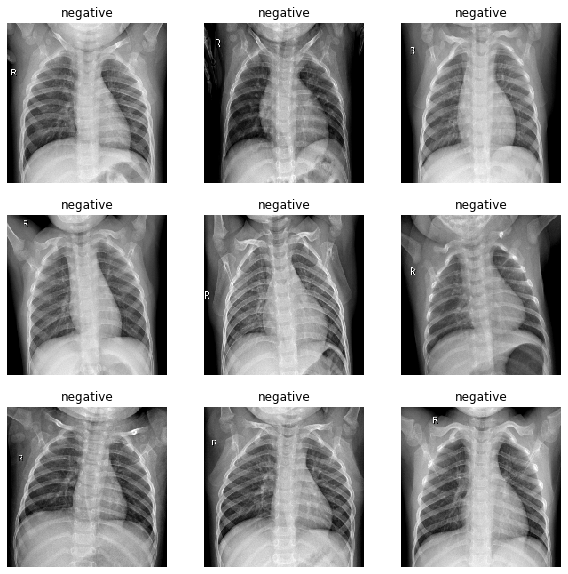

In [18]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [19]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [21]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [23]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [26]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
39/39 [==============================] - 25s 638ms/step - loss: 0.1879 - accuracy: 0.9046 - val_loss: 0.0957 - val_accuracy: 0.9679
Epoch 2/10
39/39 [==============================] - 20s 506ms/step - loss: 0.0655 - accuracy: 0.9736 - val_loss: 0.0527 - val_accuracy: 0.9776
Epoch 3/10
39/39 [==============================] - 21s 528ms/step - loss: 0.0289 - accuracy: 0.9872 - val_loss: 0.0488 - val_accuracy: 0.9776
Epoch 4/10
39/39 [==============================] - 20s 518ms/step - loss: 0.0152 - accuracy: 0.9944 - val_loss: 0.0698 - val_accuracy: 0.9808
Epoch 5/10
39/39 [==============================] - 20s 505ms/step - loss: 0.0195 - accuracy: 0.9904 - val_loss: 0.0725 - val_accuracy: 0.9808
Epoch 6/10
39/39 [==============================] - 21s 530ms/step - loss: 0.0161 - accuracy: 0.9928 - val_loss: 0.0935 - val_accuracy: 0.9840
Epoch 7/10
39/39 [==============================] - 20s 521ms/step - loss: 0.0063 - accuracy: 0.9976 - val_loss: 0.0426 - val_accuracy: 0.9872

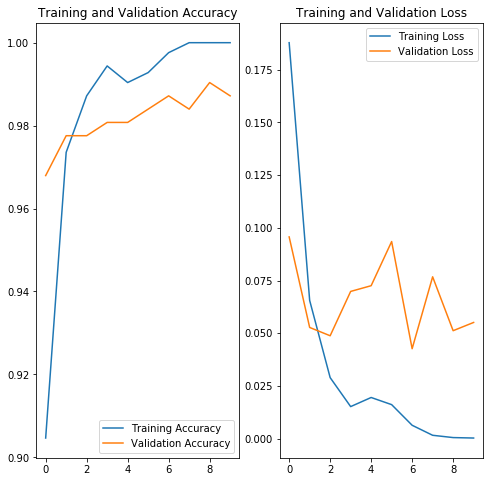

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMG_HEIGHT, 
                                                              IMG_WIDTH,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

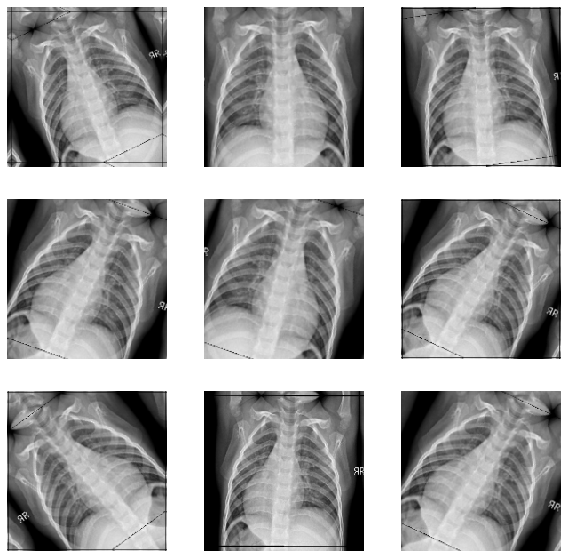

In [30]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [33]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
39/39 [==============================] - 17s 445ms/step - loss: 0.0111 - accuracy: 0.9944 - val_loss: 0.0238 - val_accuracy: 0.9904
Epoch 2/15
39/39 [==============================] - 20s 504ms/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.0420 - val_accuracy: 0.9872
Epoch 3/15
39/39 [==============================] - 20s 504ms/step - loss: 0.0024 - accuracy: 0.9992 - val_loss: 0.0351 - val_accuracy: 0.9872
Epoch 4/15
39/39 [==============================] - 20s 504ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0963 - val_accuracy: 0.9872
Epoch 5/15
39/39 [==============================] - 20s 504ms/step - loss: 0.0321 - accuracy: 0.9888 - val_loss: 0.1129 - val_accuracy: 0.9744
Epoch 6/15
39/39 [==============================] - 20s 507ms/step - loss: 0.0180 - accuracy: 0.9936 - val_loss: 0.1100 - val_accuracy: 0.9712
Epoch 7/15
39/39 [==============================] - 20s 521ms/step - loss: 0.0109 - accuracy: 0.9960 - val_loss: 0.1019 - val_accuracy: 0.9776

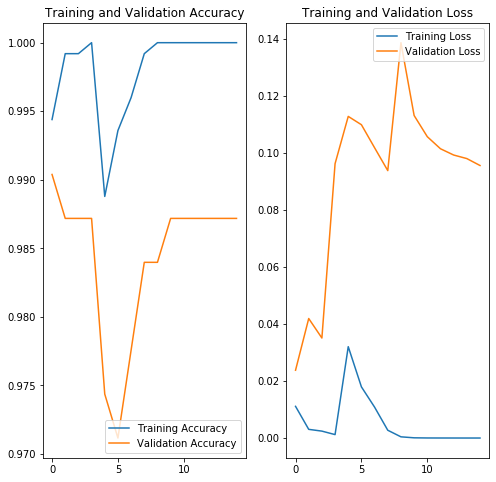

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [47]:
#test_dir = pathlib.Path(TEST_DIR)
test_neg = './TestData/CR.1.2.840.113564.192168196.2020031913094890017.1203801020003.png'
img = keras.preprocessing.image.load_img(
    test_neg
    , target_size=(IMG_HEIGHT, IMG_WIDTH)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to positive with a 100.00 percent confidence.


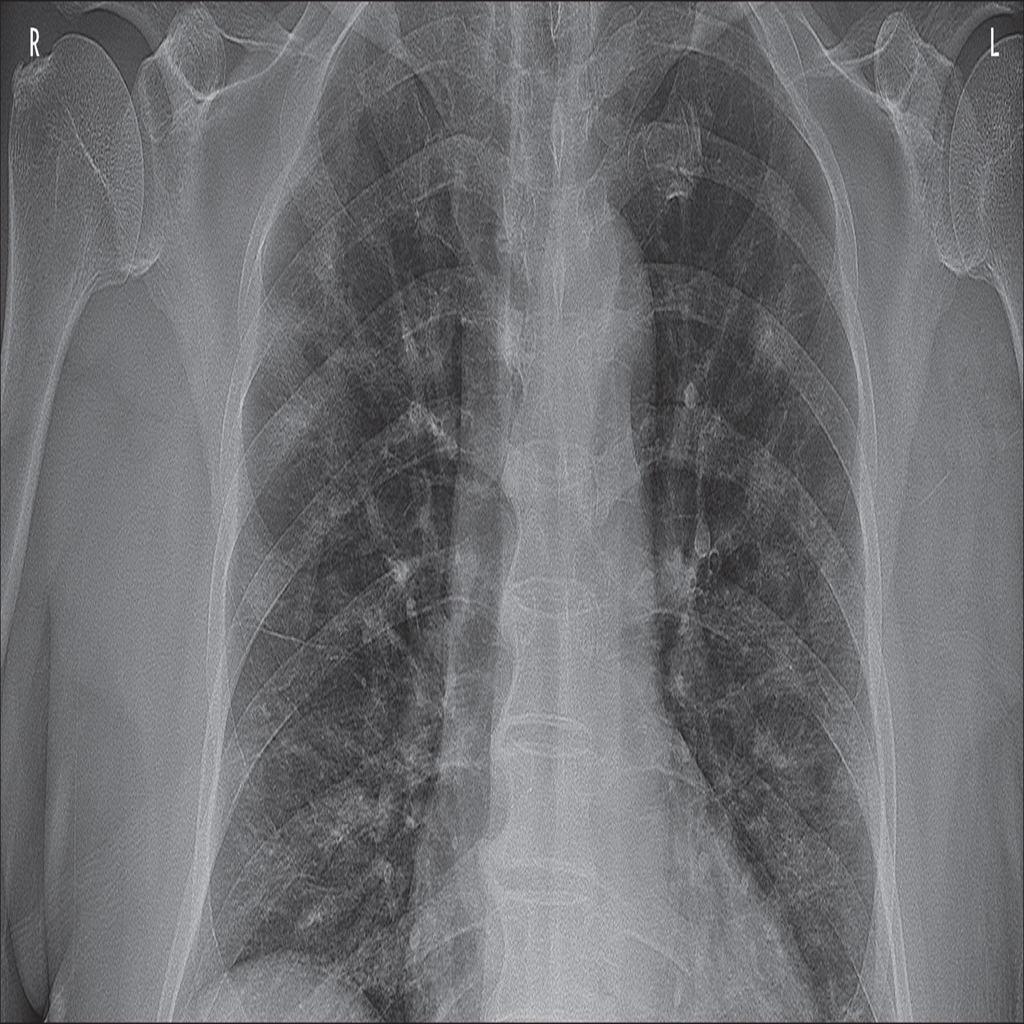

In [49]:
pos = list(data_dir.glob('positive/*'))
PIL.Image.open(str(pos[0]))

In [52]:
test_neg = './TestData/CR.1.2.840.113564.1722810170.202003211940047348.1003000225002.png'
img = keras.preprocessing.image.load_img(
    test_neg
    , target_size=(IMG_HEIGHT, IMG_WIDTH)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to positive with a 99.88 percent confidence.
